In [2]:
import math
import numpy as np
import scipy.special as sp
import random as rand
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from numba import jit,int64,float64
import time
import scipy.optimize as sciopt
%matplotlib inline

#To increase cell width:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#Color-blind friendly colors to plot:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

In [3]:
#Plot template

# fig,ax = plt.subplots(1,1)
# ax.scatter(alphas_arr,stabilities_arr[:,0],c=CB_color_cycle[0],marker=">",label="fate 1")
# ax.scatter(alphas_arr,stabilities_arr[:,1],c=CB_color_cycle[1],marker="<",label="fate 2",alpha=1)
# ax.axhline(y=stability_thresh,c="k",ls="--",label="threshold")
# ax.tick_params(axis='both', which='major', labelsize=12)
# ax.tick_params(axis='both', which='minor', labelsize=10)
# ax.set_xlabel(r"Noise coefficient $\alpha$",fontsize=18)
# ax.set_ylabel(r"Mean stability factor",fontsize=18)
# ax.legend(loc="best",fontsize=12)
# ax.set_title(f"Stability vs. noise",fontsize=20)
# fig.savefig("1b_stability_vs_noise.svg",format="svg")



In [4]:
#Parameters - self-activation a, cross-repression r, decay k, noise alpha:
a = np.array([0,0])
r = np.array([1,1])
k = np.array([1,1])
alpha = np.array([0.01,0.01])
#Hill coefficients:
n = np.array([[4,4],[4,4]])
theta = np.array([[0.5,0.5],[0.5,0.5]])

#The total time and dt::
T = 40
dt = 0.005
#Other time-related variables related to these two:
Nt = int(T/dt)
sqrt_dt = np.sqrt(dt)
TimeRange = np.arange(0,T,dt)
# #This is to calculate the dynamic threshold moving average:
# timeBase = 2*int(Nt/100)
# #Time to plot utility against:
# time_trunc = TimeRange[int((timeBase/2)-1):-int(timeBase/2)]

#Let's call num_traj the number of trajectories:
num_traj = 10000

#The initial conditions:
x0 = np.zeros((2,num_traj))
#Uniform around mean:
init_bias = 0
x0[0,:] = init_bias*np.ones(num_traj)

#The threshold above which we say x_i is high:
thresh = np.array([0.8,0.8])
#The stability threshold; a trajectory has to stay above this:
stability_thresh = 0.9

#Color-blind friendly colors to plot:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

In [4]:
#Self-activation:
@jit(nopython=True)
def activation(x,a,n,theta):
    if (x>=0):
        return (a*x**n)/(x**n + theta**n)
    else:
        return 0

#Cross-inhibition
@jit(nopython=True)
def repression(x,r,n,theta):
    if (x>0):
        return (r*theta**n)/(x**n + theta**n)
    else:
        return 0

#Bias (for external signals):
@jit(nopython=True)
def ext_bias(x1,x2,t):
#     return (x1-x2,x2-x1)
    temp = 0
    return (temp,0)
    
#This solves the system fwd using simple Euler-Maruyama:
@jit(nopython=True)
def Solver(initial,a,r,k,n,theta,alpha):
    final = np.empty((2,num_traj,Nt))
    final[:,:,0] = initial
    #Solving the system forward in time:
    for i in range(num_traj):
        for t in range(1,Nt):
            #Equation for first species:
            temp = np.sqrt(np.maximum(final[0,i,t-1],0.01))
            noise = rand.normalvariate(0,alpha[0]*temp)
            final[0,i,t] = final[0,i,t-1] + dt*(activation(final[0,i,t-1],a[0],n[0,0],theta[0,0]) \
                                               + repression(final[1,i,t-1],r[0],n[1,0],theta[1,0]) \
                                               - k[0]*final[0,i,t-1] + ext_bias(final[0,i,t-1],final[1,i,t-1],t)[0]) \
                                                + sqrt_dt*noise
            #Equation for second:
            temp = np.sqrt(np.maximum(final[1,i,t-1],0.01))
            noise = rand.normalvariate(0,alpha[1]*temp)
            final[1,i,t] = final[1,i,t-1] + dt*(activation(final[1,i,t-1],a[1],n[1,1],theta[1,1]) \
                                               + repression(final[0,i,t-1],r[1],n[0,1],theta[0,1]) \
                                               - k[1]*final[1,i,t-1] + ext_bias(final[0,i,t-1],final[1,i,t-1],t)[1]) \
                                                + sqrt_dt*noise
    return final

#Classifier:
# @jit(nopython=True)
def fate_classifier(traj,thresh,stability_thresh):
    #Stability factor of trajectories:
    cross_flags = np.zeros((2,num_traj))
    cross_times = np.ones((2,num_traj))*Nt
    for axis_idx in range(2):
        #Axis crossings:
        for traj_idx in range(num_traj):
            if (np.size(np.where(traj[axis_idx,traj_idx]>thresh[axis_idx])[0]) != 0):
                cross_flags[axis_idx,traj_idx] = 1
                cross_times[axis_idx,traj_idx] = np.where(traj[axis_idx,traj_idx]>thresh[axis_idx])[0][0]
                    
    #Stability factor: after the threshold is crossed, how much time the traj spends above it:
    stability_factrs = np.zeros((2,num_traj))
    for axis_idx in range(2):
        for traj_idx in range(num_traj):
#             if (cross_flags[axis_idx,traj_idx]==0):
#                 stability_factrs[axis_idx,traj_idx] = -1
            if (cross_flags[axis_idx,traj_idx]==1):
                stability_factrs[axis_idx,traj_idx] = np.sum(traj[axis_idx,traj_idx,int(cross_times[axis_idx,traj_idx]):]>thresh[axis_idx])\
                /len(traj[axis_idx,traj_idx,int(cross_times[axis_idx,traj_idx]):])
    
    #Stability threshold - trajectories that spend more than this above the concentration threshold are considered committed:
#     stability_thresh = 0.8
    #Classifying fates:
    fates = np.zeros((2,num_traj))
    for axis_idx in range(2):
        for traj_idx in range(num_traj):
            if (cross_times[axis_idx,traj_idx]<=int(Nt/2) and stability_factrs[axis_idx,traj_idx]>=stability_thresh):
                fates[axis_idx,traj_idx]=1
                
    return stability_factrs,fates

def fate_fractions(fates):
    #Initializing:
    fate_frax = np.zeros(4)
    fate_frax[0] = np.sum((fates[0]==0) & (fates[1]==0))/num_traj
    fate_frax[1] = np.sum((fates[0]==1) & (fates[1]==0))/num_traj
    fate_frax[2] = np.sum((fates[0]==0) & (fates[1]==1))/num_traj
    fate_frax[3] = np.sum((fates[0]==1) & (fates[1]==1))/num_traj
    
    return fate_frax

def traj_moments(traj,fates):
    #Finding the fate fractions first:
    fate_frax = fate_fractions(fates)
    
    #Flags, if fate_frac is zero for a fate then no avg or std is calculated:
    fate_flags = np.array([False for i in range(4)])
    
    #Flag = True if that fate exists in the population:
    for fate_idx in range(4):
        if (fate_frax[fate_idx] != 0):
            fate_flags[fate_idx] = True
            
    #Average trajectories and standard deviation around them:
    avg_traj = np.zeros((4,2,Nt))
    std_traj = np.zeros((4,2,Nt))
    
    if (fate_flags[0]==True):
        avg_traj[0,:,:] = np.mean(traj[:,(fates[0]==0) & (fates[1]==0),:],axis=1)
        std_traj[0,:,:] = np.std(traj[:,(fates[0]==0) & (fates[1]==0),:],axis=1)

    if (fate_flags[1]==True):
        avg_traj[1,:,:] = np.mean(traj[:,(fates[0]==1) & (fates[1]==0),:],axis=1)
        std_traj[1,:,:] = np.std(traj[:,(fates[0]==1) & (fates[1]==0),:],axis=1)

    if (fate_flags[2]==True):
        avg_traj[2,:,:] = np.mean(traj[:,(fates[0]==0) & (fates[1]==1),:],axis=1)
        std_traj[2,:,:] = np.std(traj[:,(fates[0]==0) & (fates[1]==1),:],axis=1)

    if (fate_flags[3]==True):
        avg_traj[3,:,:] = np.mean(traj[:,(fates[0]==1) & (fates[1]==1),:],axis=1)
        std_traj[3,:,:] = np.std(traj[:,(fates[0]==1) & (fates[1]==1),:],axis=1)
        
    return (avg_traj,std_traj)

In [5]:
#Generating some trajectories:
start_time = time.time()
traj_simple = np.empty((2,num_traj,Nt))
traj_simple = Solver(x0,a,r,k,n,theta,alpha)
end_time = time.time()
loop_time = end_time - start_time
print(f"Time taken: {loop_time} s.")

Time taken: 14.021469831466675 s.


In [6]:
#Now testing the fates and stability factors:
stability_factrs,fates = fate_classifier(traj_simple,thresh,stability_thresh)

In [7]:
#Varying initial bias and calculating the sensitivity:
init_bias_arr = np.array([(i)/100 for i in range(6)])
#Finding stabilities:
stabilities_mean_arr = np.zeros((len(init_bias_arr),2))
stabilities_std_arr = np.zeros((len(init_bias_arr),2))
fate_frax = np.zeros((len(init_bias_arr),4))

for bias_idx in range(len(init_bias_arr)):
    #The bias:
    init_bias = init_bias_arr[bias_idx]
    #Initial conditions:
    x0 = np.zeros((2,num_traj))
    x0[0,:] = init_bias*np.ones(num_traj)
    #Evolving:
    traj_init_bias = Solver(x0,a,r,k,n,theta,alpha)
    #Checking fates:
    stability_factrs,fates = fate_classifier(traj_init_bias,thresh,stability_thresh)
    #Finding fate fractions:
    fate_frax[bias_idx,0] = np.sum((fates[0]==0) & (fates[1]==0))
    fate_frax[bias_idx,1] = np.sum((fates[0]==1) & (fates[1]==0))
    fate_frax[bias_idx,2] = np.sum((fates[0]==0) & (fates[1]==1))
    fate_frax[bias_idx,3] = np.sum((fates[0]==1) & (fates[1]==1))
    #Finding mean stabilities:
    for axis_idx in range(2):
        stabilities_mean_arr[bias_idx,axis_idx] = np.mean(stability_factrs[axis_idx,stability_factrs[axis_idx]>0])
        stabilities_std_arr[bias_idx,axis_idx] = np.std(stability_factrs[axis_idx,stability_factrs[axis_idx]>0])
    
fate_frax = fate_frax/num_traj

/home/ssengupt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ssengupt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ssengupt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ssengupt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/ssengupt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


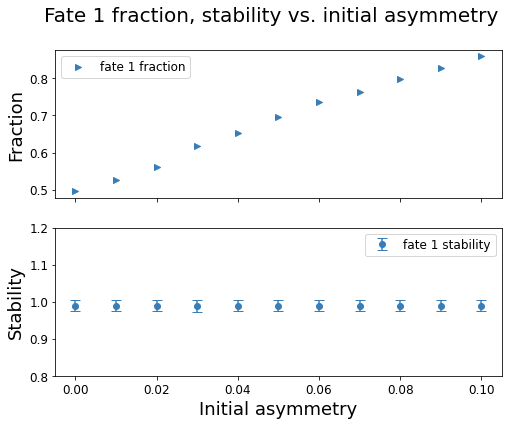

In [72]:
#Plot template -> theta=0.5:

fig,ax = plt.subplots(2,1,sharex=True,figsize=[8,6])
ax[0].scatter(init_bias_arr,fate_frax[:,1],c=CB_color_cycle[0],marker=">",label="fate 1 fraction")
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].tick_params(axis='both', which='minor', labelsize=10)
# ax[0].set_xlabel(r"Initial asymmetry",fontsize=18)
ax[0].set_ylabel(r"Fraction",fontsize=18)
ax[0].legend(loc="best",fontsize=12)
# ax[0].set_title(f"Final vs. inital asymmetry",fontsize=20)

ax[1].errorbar(init_bias_arr,stabilities_mean_arr[:,0],yerr=stabilities_std_arr[:,0],c=CB_color_cycle[0],capsize=5,fmt="o",label="fate 1 stability")
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='minor', labelsize=10)
ax[1].set_xlabel(r"Initial asymmetry",fontsize=18)
ax[1].set_ylabel(r"Stability",fontsize=18)
ax[1].set_ylim([0.8,1.2])
ax[1].legend(loc="best",fontsize=12)
# ax[1].set_title(f"Stability vs. inital asymmetry",fontsize=20)

fig.suptitle("Fate 1 fraction, stability vs. initial asymmetry",fontsize=20)

fig.savefig("2a_fraction,stability_vs_initial.pdf",format="pdf")

In [21]:
#Varying initial bias and calculating the sensitivity:
init_bias_arr = np.array([i/100 for i in range(11)])
#Thetas:
thetas_arr = np.array([0.3,0.5,0.7])
# #Stabilities:
# stabilities_mean_arr = np.zeros((len(thetas_arr),len(init_bias_arr),2))
# stabilities_std_arr = np.zeros((len(thetas_arr),len(init_bias_arr),2))
#Fate fractions:
fate_frax = np.zeros((len(thetas_arr),len(init_bias_arr),4))

for theta_idx in range(len(thetas_arr)):
    #Setting theta:
    theta[0,1] = theta[1,0] = thetas_arr[theta_idx]
    for bias_idx in range(len(init_bias_arr)):
        #Initial conditions:
        x0 = np.zeros((2,num_traj))
        x0[0,:] = init_bias_arr[bias_idx]*np.ones(num_traj)
        #Evolving trajectories:
        traj_theta_bias = np.empty((2,num_traj,Nt))
        traj_theta_bias = Solver(x0,a,r,k,n,theta,alpha)
        #Checking fates and finding fate frax:
        stability_factrs,fates = fate_classifier(traj_theta_bias,thresh,stability_thresh)
        fate_frax[theta_idx,bias_idx] = fate_fractions(fates)
#         #Finding mean stabilities:
#         for axis_idx in range(2):
#             stabilities_mean_arr[theta_idx,bias_idx,axis_idx] = np.mean(stability_factrs[axis_idx,stability_factrs[axis_idx]>0])
#             stabilities_std_arr[theta_idx,bias_idx,axis_idx] = np.std(stability_factrs[axis_idx,stability_factrs[axis_idx]>0])

In [27]:
#Writing data to file:
np.savetxt(fr"2a_fatefrax_alpha={alpha[0]}.txt",fate_frax.flatten())

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


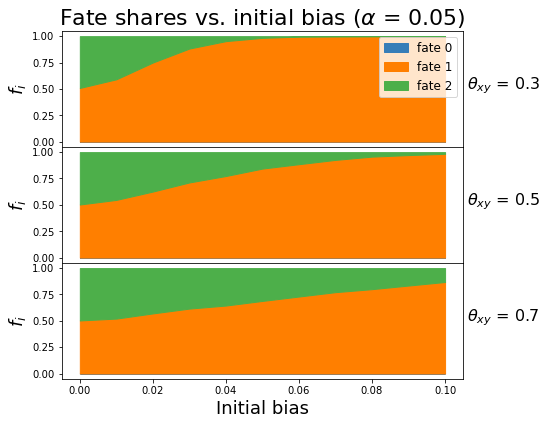

In [25]:
#Proportions of fates 0, 1 and 2:
fig,ax = plt.subplots(3,1,figsize=[7.2,6.4],sharex=True,sharey=True)

ax[0].fill_between(init_bias_arr,y1=fate_frax[0,:,0],color=CB_color_cycle[0],alpha=1,label="fate 0")
ax[0].fill_between(init_bias_arr,y1=fate_frax[0,:,1]+fate_frax[0,:,0],y2=fate_frax[0,:,0],color=CB_color_cycle[1],alpha=1,label="fate 1")
ax[0].fill_between(init_bias_arr,y1=fate_frax[0,:,2]+fate_frax[0,:,1]+fate_frax[0,:,0],y2=fate_frax[0,:,1]+fate_frax[0,:,0],color=CB_color_cycle[2],alpha=1,label="fate 2")
ax[0].legend(loc="best",fontsize=12)
ax[0].set_ylabel(r"$f_i$",fontsize=18)
ax[0].text(1.01,0.5,fr"$\theta_{{xy}}$ = {thetas_arr[0]}",transform=ax[0].transAxes,fontsize=16)
ax[0].set_title(fr"Fate shares vs. initial bias ($\alpha$ = {alpha[0]})",fontsize=22)

ax[1].fill_between(init_bias_arr,y1=fate_frax[1,:,0],color=CB_color_cycle[0],alpha=1)
ax[1].fill_between(init_bias_arr,y1=fate_frax[1,:,1]+fate_frax[1,:,0],y2=fate_frax[1,:,0],color=CB_color_cycle[1],alpha=1)
ax[1].fill_between(init_bias_arr,y1=fate_frax[1,:,2]+fate_frax[1,:,1]+fate_frax[1,:,0],y2=fate_frax[1,:,1]+fate_frax[1,:,0],color=CB_color_cycle[2],alpha=1)
ax[1].set_ylabel(r"$f_i$",fontsize=18)
ax[1].text(1.01,0.5,fr"$\theta_{{xy}}$ = {thetas_arr[1]}",transform=ax[1].transAxes,fontsize=16)

ax[2].fill_between(init_bias_arr,y1=fate_frax[2,:,0],color=CB_color_cycle[0],alpha=1)
ax[2].fill_between(init_bias_arr,y1=fate_frax[2,:,1]+fate_frax[2,:,0],y2=fate_frax[2,:,0],color=CB_color_cycle[1],alpha=1)
ax[2].fill_between(init_bias_arr,y1=fate_frax[2,:,2]+fate_frax[2,:,1]+fate_frax[2,:,0],y2=fate_frax[2,:,1]+fate_frax[2,:,0],color=CB_color_cycle[2],alpha=1)
ax[2].set_ylabel(r"$f_i$",fontsize=18)
ax[2].text(1.01,0.5,fr"$\theta_{{xy}}$ = {thetas_arr[2]}",transform=ax[2].transAxes,fontsize=16)
ax[2].set_xlabel(r"Initial bias",fontsize=18)

plt.subplots_adjust(wspace=0, hspace=0)

fig.savefig("2a_fatefrax_vs_bias.eps",format="eps",dpi=2000,bbox_inches="tight",pad_inches=0.15)